<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/dataclean_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_state=42

In [3]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1sPoe6p1zKBOZQcQWsTTl0wzE9WCreffo/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  app_df=pd.read_csv(url,index_col=0)
else:
  pathtodataset="./content/credit_record.csv"
  app_df=pd.read_csv(pathtodataset,index_col=0)

In [4]:
app_df.head()

,id,gender,own_car,own_realty,num_child,income,income_type,education_level,family_status,house_type,birth_day,employment_length,mobile,work_phone,phone,email,job,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
app_df.describe()

,id,num_child,income,birth_day,employment_length,mobile,work_phone,phone,email,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [6]:
app_df["mobile"].unique()

array([1])

Everyone has a mobile phone, we should drop this redundant factor (cardinality=1) to reduce the dimesionality of our data

In [7]:
prev_df=app_df.drop(columns=["mobile"],inplace=True)

In [8]:
missing_values_count = app_df.isnull().sum()

In [9]:
missing_values_count

id                        0
gender                    0
own_car                   0
own_realty                0
num_child                 0
income                    0
income_type               0
education_level           0
family_status             0
house_type                0
birth_day                 0
employment_length         0
work_phone                0
phone                     0
email                     0
job                  134203
CNT_FAM_MEMBERS           0
dtype: int64

The only column with missing values is the job column.

There are some pensioners that are still working and the rest are unemployed. We will label the non-working pensioner with job of pensioner.

In [10]:
pensioners_not_working=app_df[app_df['employment_length']>=0]
pensioners_not_working["income_type"].unique()

array(['Pensioner'], dtype=object)

all the people with employment_length>= 0 (unemployed) are pensioners so we can simply fillna with `'Pensioner'` as only the job col is na

In [11]:
pensioners_not_working=pensioners_not_working.fillna('Pensioner')

In [12]:
pensioners_not_working['employment_length'].describe()

count     75329.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: employment_length, dtype: float64

In [13]:
pensioners_not_working['birth_day'].describe()

count    75329.000000
mean    -21715.424272
std       1839.857354
min     -25201.000000
25%     -22981.000000
50%     -21927.000000
75%     -20807.000000
max      -8145.000000
Name: birth_day, dtype: float64

Having the pensioners with employment length = 365243 is both incorrect (1000 years) and will definitely affect the feature scaling of employment length. Thus , we propose that the retirement age is the median of the dataset 21927 (60 years old) and employment length which is long they have been pensioners will be max(median-age,0).

In [14]:
pd.options.mode.chained_assignment = None
pensioners_not_working["employment_length"]=pensioners_not_working.apply(lambda x : max(-21927-x["birth_day"],0),axis=1)

In [15]:
employed=app_df[app_df['employment_length']<0]

In [16]:
employed_pen=employed[employed["income_type"]=='Pensioner']
employed_pen[~employed_pen["job"].isna()]

,id,gender,own_car,own_realty,num_child,income,income_type,education_level,family_status,house_type,birth_day,employment_length,work_phone,phone,email,job,CNT_FAM_MEMBERS
434476,5010868,M,Y,Y,1,450000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-18173,-678,0,1,1,Core staff,3.0
434547,5045929,M,N,N,0,247500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-15037,-2208,0,0,0,Laborers,1.0
434551,5046328,F,N,Y,1,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-15466,-2269,0,1,0,Low-skill Laborers,3.0
434590,5054386,M,Y,N,0,292500.0,Pensioner,Higher education,Single / not married,House / apartment,-14050,-3680,1,1,0,Laborers,1.0
434656,5092394,M,Y,Y,1,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-11050,-443,1,0,0,Drivers,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438394,6779887,M,Y,Y,2,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-11653,-2018,0,0,1,Drivers,4.0
438464,6801596,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-13659,-4235,0,0,0,Core staff,2.0
438476,6806483,M,Y,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-17872,-1495,0,1,0,Laborers,1.0
438485,6815341,F,N,Y,0,126000.0,Pensioner,Higher education,Married,House / apartment,-18856,-1449,1,1,0,Core staff,2.0


Some pensioners can still have jobs but are receiving a pension

In [17]:
employed.isna().sum()

id                       0
gender                   0
own_car                  0
own_realty               0
num_child                0
income                   0
income_type              0
education_level          0
family_status            0
house_type               0
birth_day                0
employment_length        0
work_phone               0
phone                    0
email                    0
job                  58874
CNT_FAM_MEMBERS          0
dtype: int64

In [18]:
cond=employed['job'].notnull()
predict_df= employed[~cond]
df=employed[cond]

In [20]:
print(predict_df.shape)
print(df.shape)

(58874, 17)
(304354, 17)


Id is a redundant factor but we have to keep id for `predict_df` when we want to merge the predicted df later

In [21]:
train_df=df.drop("id",axis=1,inplace=False)

We can use a decision tree to predict the job of the person if we assume our data (n=304354) covers the majority of jobs that we will encounter (no outlier jobs). 

The following code is inspired by https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [22]:
from sklearn.model_selection import ShuffleSplit
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from fastai.tabular.all import *

In [23]:
dep_var="job"

In [24]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [25]:
procs = [Categorify]

In [26]:
cont,cat = cont_cat_split(train_df, 1, dep_var=dep_var)

In [27]:
to = TabularPandas(train_df, procs, cat, cont, y_names=dep_var, splits=splits)

In [28]:
len(to.train),len(to.valid)

(243483, 60871)

In [29]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [30]:
m = DecisionTreeClassifier(max_depth=18,random_state=random_state)
m.fit(xs, y)

DecisionTreeClassifier(max_depth=18, random_state=42)

In [31]:
class_names2pass = sorted(train_df["job"].unique())

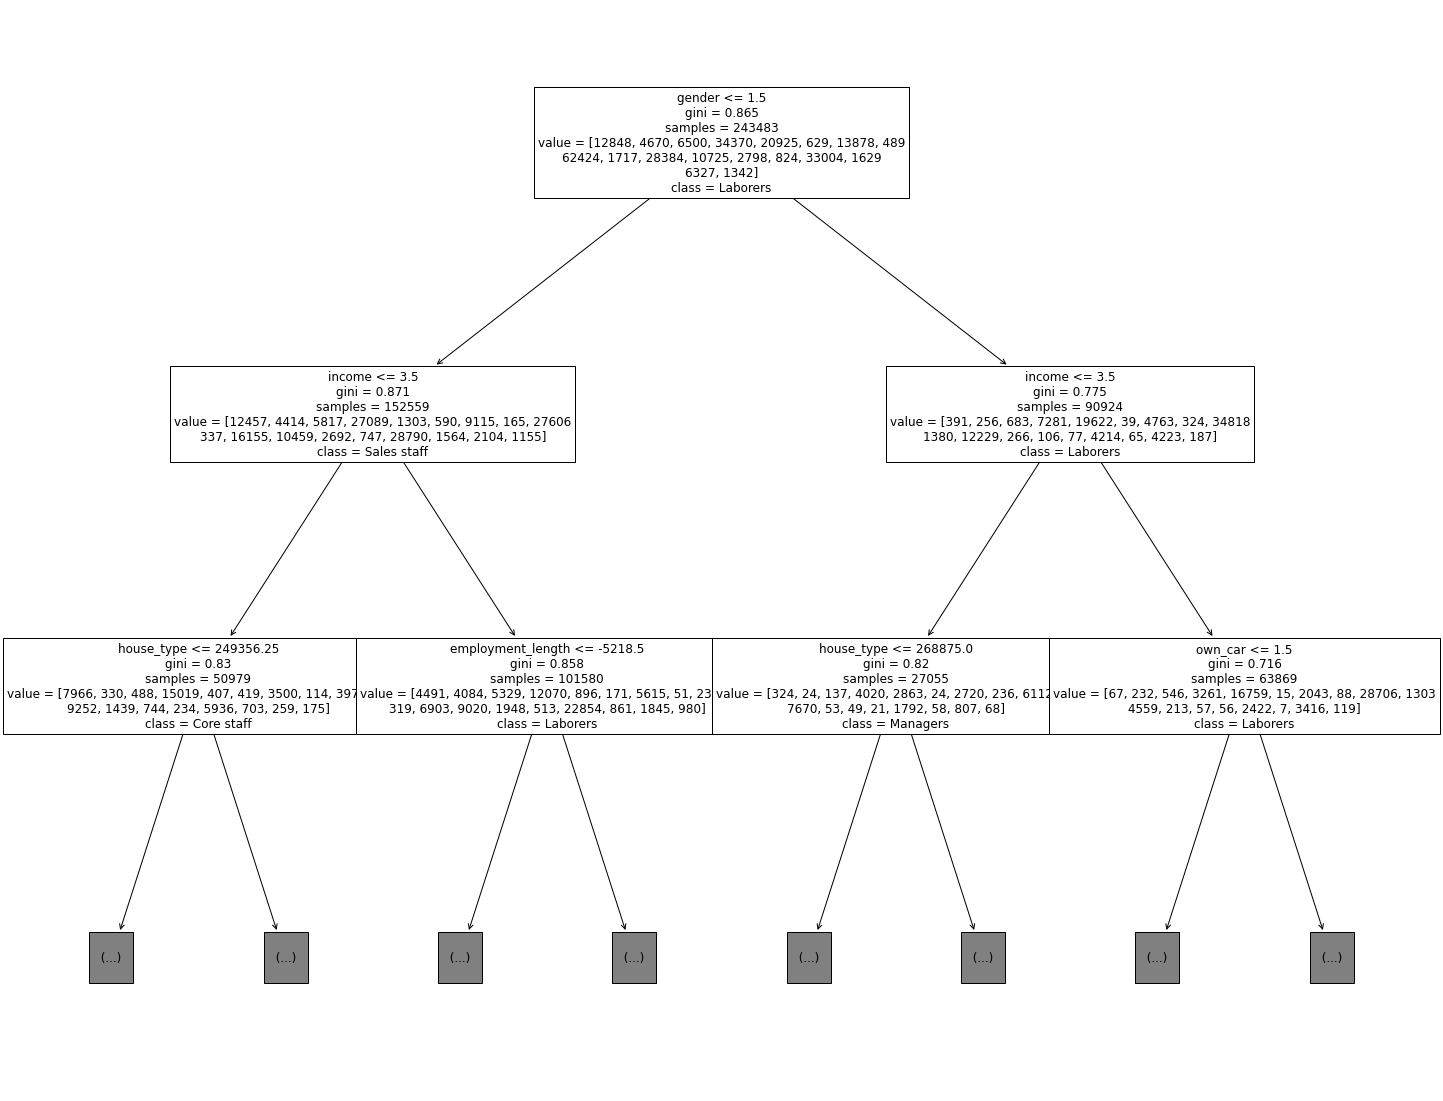

In [66]:
fig = plt.figure(figsize=(25,20))
var = plot_tree(m,feature_names=train_df.columns, class_names=class_names2pass,max_depth=2,fontsize=12)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [36]:
def hamming_distance(x,y):
  return sum(x!=y)/len(x)

In [37]:
def m_hamming_distance_accuracy(m, xs, y): return 1-hamming_distance(m.predict(xs), y)

In [38]:
# training score
m_hamming_distance_accuracy(m, xs, y)

0.6953175375693581

In [39]:
#cv score
m_hamming_distance_accuracy(m, valid_xs,valid_y)

0.6571766522646252

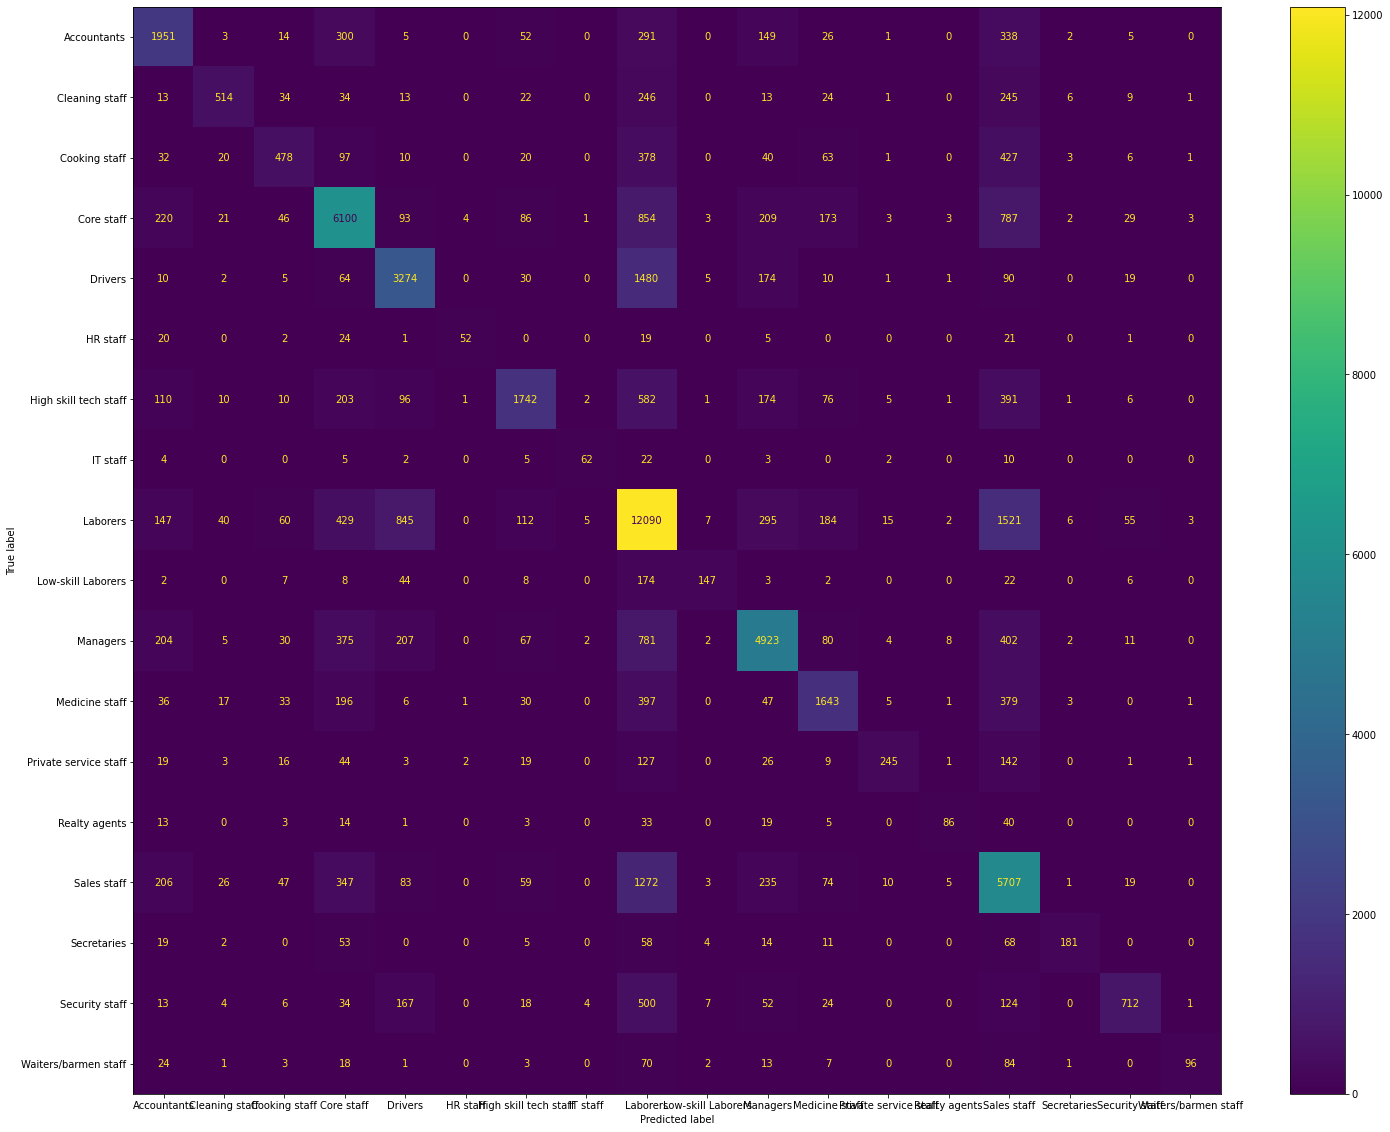

In [40]:
# get the labels to not overlay
disp=ConfusionMatrixDisplay.from_estimator(m,valid_xs, valid_y,display_labels=class_names2pass)
fig=disp.ax_.get_figure() 
fig.set_figwidth(25)
fig.set_figheight(20) 

This baseline decision tree is ok with an accuracy of ~0.7.
However, it seems to be overfitting as the cv is ~4% less than training

Perhaps we could use random forests

In [41]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,random_state=random_state).fit(xs, y)

In [42]:
rf_m = rf(xs, y);

In [43]:
m_hamming_distance_accuracy(rf_m, xs, y), m_hamming_distance_accuracy(rf_m, valid_xs, valid_y)

(0.942176661204273, 0.8832613231259548)

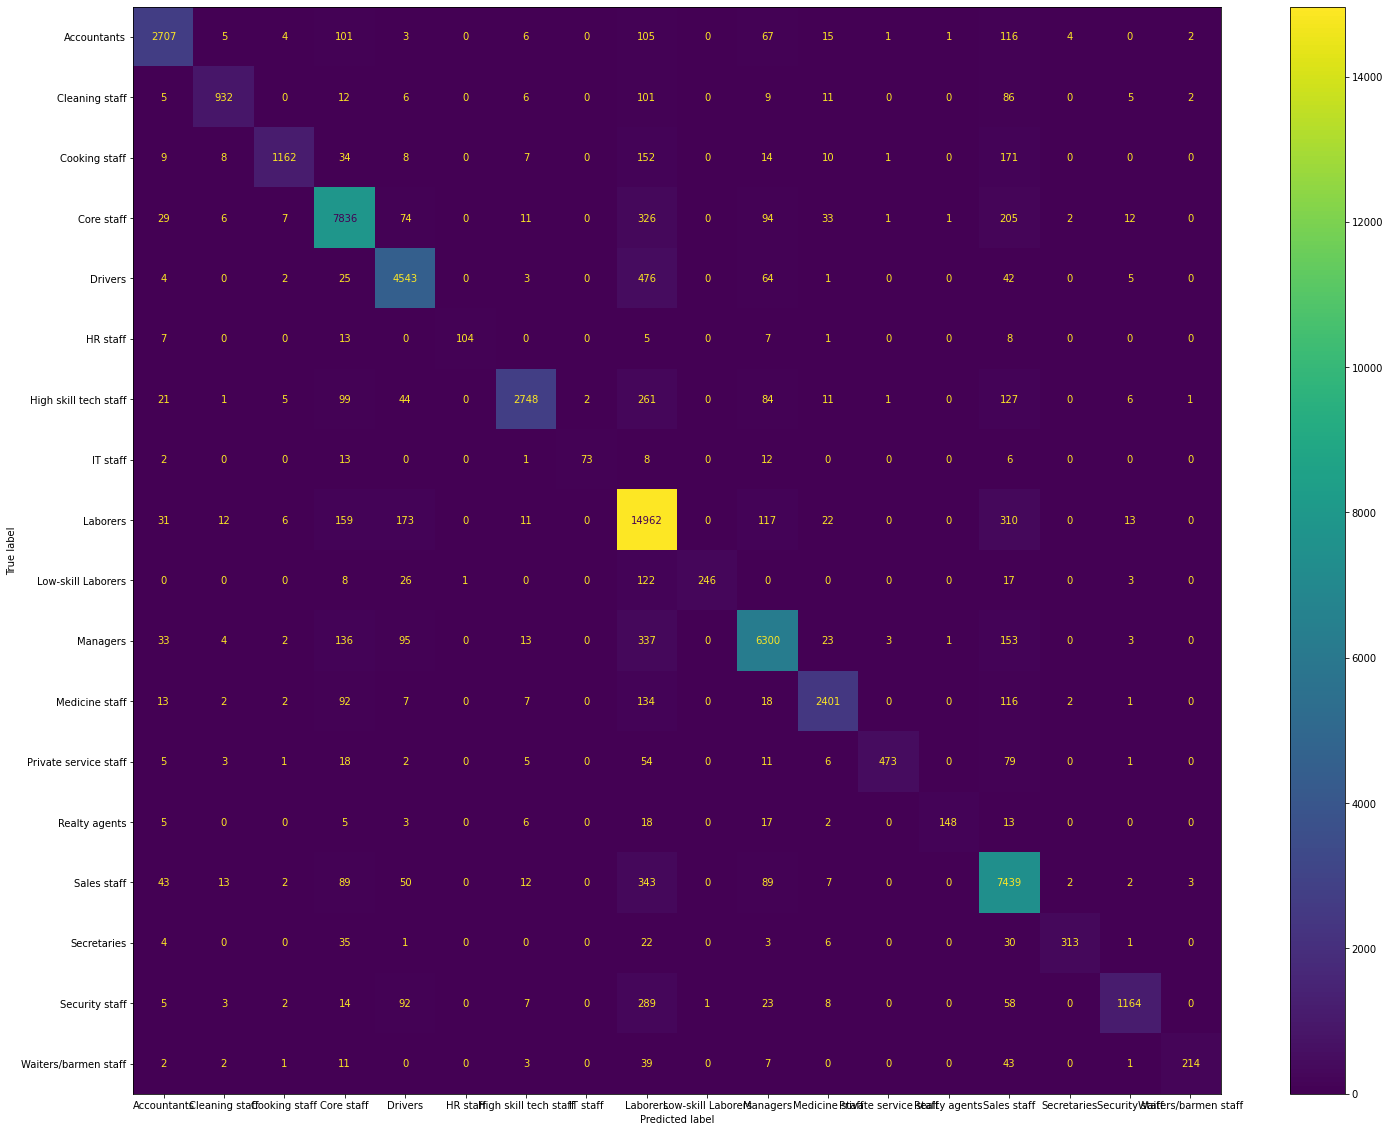

In [44]:
disp=ConfusionMatrixDisplay.from_estimator(rf_m,valid_xs, valid_y,display_labels=class_names2pass)
fig=disp.ax_.get_figure() 
fig.set_figwidth(25)
fig.set_figheight(20) 

Random forests do way better! However, it still seems to be overfitting.

Feature Importance

In [45]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [46]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
10,employment_length,0.240387
9,birth_day,0.229754
8,income,0.135957
0,gender,0.062724
4,education_level,0.060078
5,family_status,0.040568
3,income_type,0.036701
14,CNT_FAM_MEMBERS,0.033499
2,own_realty,0.024869
6,house_type,0.024184


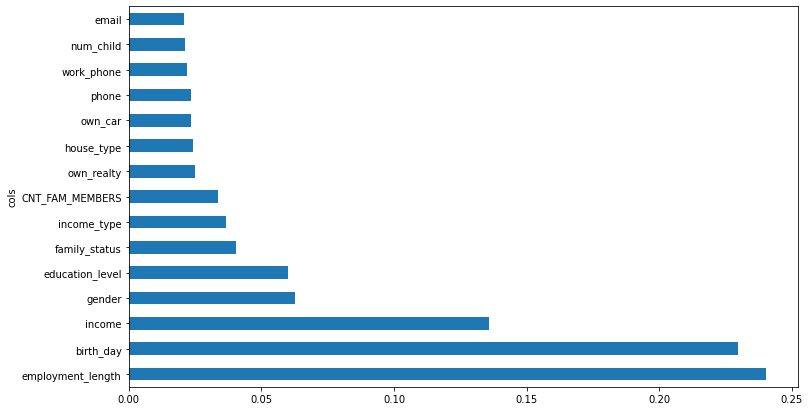

In [47]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

We could also use gradient boosted trees to predict the jobs

In [48]:
from lightgbm import LGBMClassifier

In [49]:
boosted_tree=LGBMClassifier(random_state=random_state)

In [50]:
#boosted_tree.fit(xs,y)

In [51]:
#boosted_tree.score(valid_xs,valid_y)

In [52]:
#m_hamming_distance_accuracy(boosted_tree, xs, y), m_hamming_distance_accuracy(boosted_tree, valid_xs, valid_y)

It seems there is something wrong with our current lgbm, perhaps we could change the hyper parameters

We would be using the random forest to predict the missing jobs

In [53]:
# use same pipeline to convert df
predict_to = TabularPandas(predict_df, procs, cat, cont, y_names=dep_var)
predict_xs = predict_to.train.xs
predicted_jobs=rf_m.predict(predict_xs)
predicted_jobs_names=[class_names2pass[i] for i in predicted_jobs]
concat_df=predict_df.assign(job=predicted_jobs_names)

In [54]:
cleaned_df=pd.concat([concat_df,df,pensioners_not_working]).sort_values("id")

In [58]:
cleaned_df.shape

(438557, 17)

In [59]:
cleaned_df.isnull().sum()

id                   0
gender               0
own_car              0
own_realty           0
num_child            0
income               0
income_type          0
education_level      0
family_status        0
house_type           0
birth_day            0
employment_length    0
work_phone           0
phone                0
email                0
job                  0
CNT_FAM_MEMBERS      0
dtype: int64

In [60]:
cleaned_df.to_csv("cleaned_application.csv")